In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from lib import *

# needed for ipython to reload local module every run
%load_ext autoreload
%autoreload 1
%aimport lib, lib.linear, lib.quadratic
plt.style.use("seaborn-v0_8")

L2 Error: 0.0556


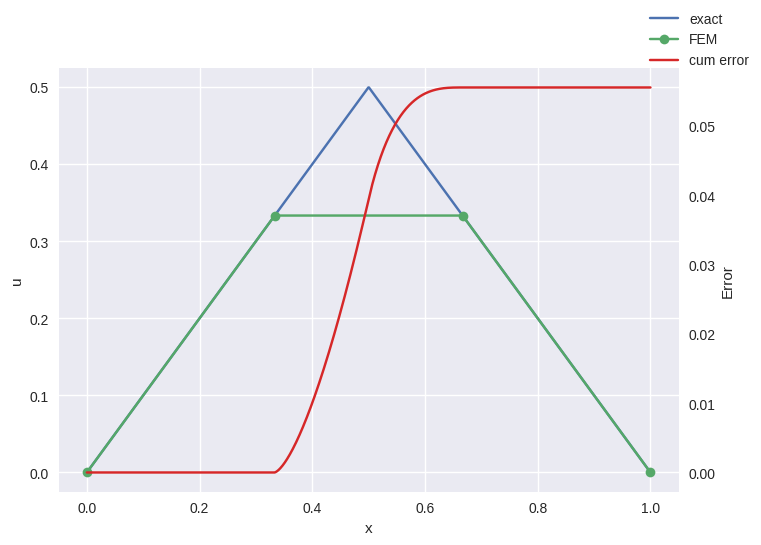

In [38]:
x0, xN = 0, 1
N = 3
h = (xN - x0) / (N)  # N+1 nodes means N intervals

# get analytical solution u, f(x), coefficients b and matrix elements a_ij
u_f, u_fpp, u_b, u_a_ij = funcs["f2_lin"]

a = np.array([[u_a_ij(i, j, h) for j in range(1, N)] for i in range(1, N)])
b = np.array([u_b(i, h) for i in range(1, N)])
# b = np.array([b_j(i, h, u_fpp, x0, xN) for i in range(1, N)])
x = np.linalg.solve(a, b)

fig, ax = plt.subplots()

fine_x = np.linspace(x0, xN, num=1000)
u_anal = u_f(fine_x)
ax.plot(fine_x, u_anal, label="exact")

x_grid = np.linspace(x0, xN, num=N + 1)
# for basis = hat functions b = u_N(x_k),
# but we only have N-1 b_k corresponding to u_N(x_1) to x_N(x_(N-1))
# so we pad with zero left and right to get u_N(boundary)=0
u_num_corse = np.pad(x, 1, "constant", constant_values=0)
ax.plot(x_grid, u_num_corse, "-o", label="FEM")

# plotting high resolution version of function
u_num_fine = constr_f(x, fine_x, h)
# ax.plot(fine_x, u_num_fine)

# print(a)

error = np.sqrt(
    np.cumsum((u_anal - u_num_fine) ** 2) * (fine_x[1] - fine_x[0])
)  # approximate integral by sum


l2_error = l2_err_func(u_f, u_num_corse, x_grid)
print(f"L2 Error: {l2_error:#.3}")


ax2 = ax.twinx()
ax2.plot(fine_x, error, color="tab:red", label="cum error")
ax2.grid(False)

ax.set_xlabel("x")
ax.set_ylabel("u")
ax2.set_ylabel("Error")
_ = fig.legend()

  L1 Error = 2.9e-09*N^-0.62
  L2 Error = 4.1e-09*N^-0.41
Linf Error = 3.0e-07*N^-4.1


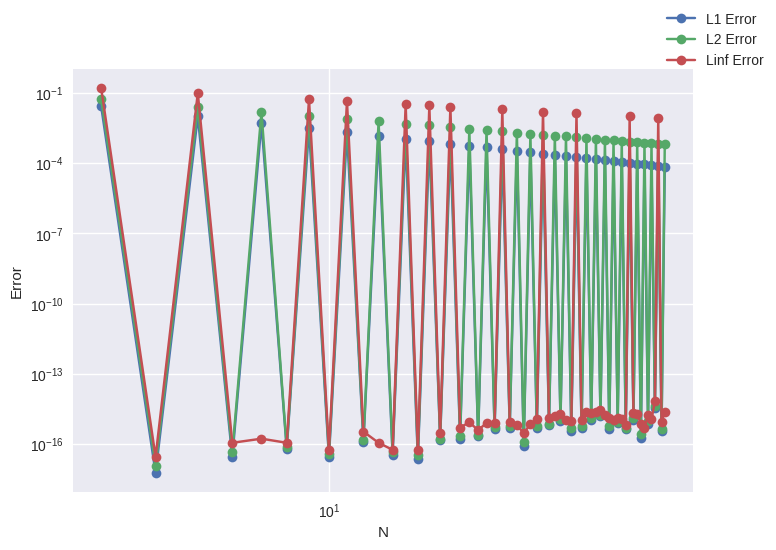

In [ ]:
# plot errors over N

u_f, u_fpp, u_b, u_a_ij = funcs["f2_lin"]

x0, xN = 0, 1
fine_x = np.linspace(x0, xN, num=10000)

u_anal = u_f(fine_x)

temp1, temp2, temp3 = [], [], []

ns = np.logspace(
    np.log2(3) // 1, np.log2(200) // 1, base=2, dtype=int, num=20
)  # get k integers between a,b evenly spaced in logspace

# ns = np.arange(3, 60)

fig, ax = plt.subplots()

for N in ns:
    print(f"N:{N}", end="\r")  # counter for computation
    h = (xN - x0) / (N)

    a = np.array([[u_a_ij(i, j, h) for j in range(1, N)] for i in range(1, N)])
    b = np.array([u_b(i, h) for i in range(1, N)])
    # b = np.array([b_j(i, h, used_fpp, x0, xN) for i in range(1, N)]) # numerical b
    x = np.linalg.solve(a, b)

    x_grid = np.linspace(x0, xN, num=N + 1)
    u_num_corse = np.pad(x, 1, "constant", constant_values=0)

    temp1.append(l1_err_func(u_f, u_num_corse, x_grid))
    temp2.append(l2_err_func(u_f, u_num_corse, x_grid))
    temp3.append(linf_err_func(u_f, u_num_corse, x_grid))


l1_errors = np.array(temp1)
l2_errors = np.array(temp2)
linf_errors = np.array(temp3)

ax.plot(ns, l1_errors, "-o", label="L1 Error")
ax.plot(ns, l2_errors, "-o", label="L2 Error")
ax.plot(ns, linf_errors, "-o", label="Linf Error")

ax.set_xlabel("N")
ax.set_ylabel("Error")
ax.set_xscale("log")
ax.set_yscale("log")
fig.legend()

for errors, label in zip(
    [l1_errors, l2_errors, linf_errors], ["L1 Error", "L2 Error", "Linf Error"]
):
    # as y = c x^n
    # log(y) = log(c) + n*log(x)
    # so we find the convergence order n by linear regression
    slope, intercept = np.polyfit(np.log(ns), np.log(errors), 1)
    print(f"{label:>10} = {np.exp(intercept):#0.2}*N^{slope:#.2}")

L2 Error: 0.00277


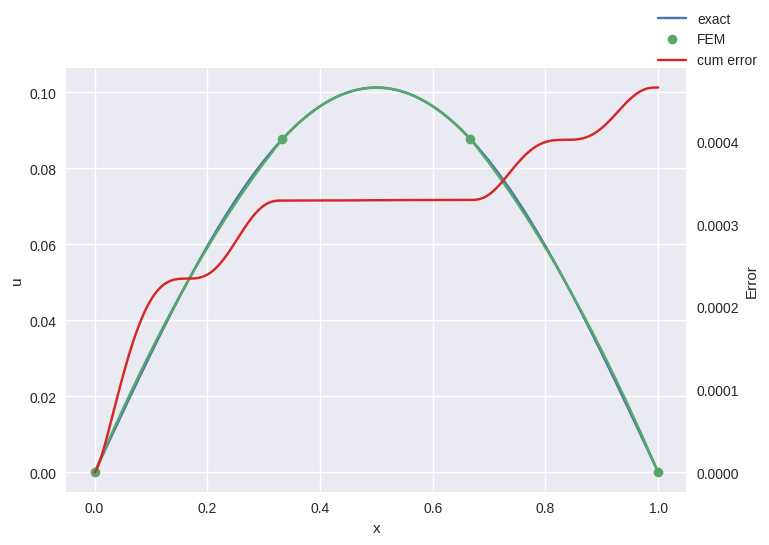

In [47]:
x0, xN = 0, 1
N = 3
h = (xN - x0) / (N)  # N+1 nodes means N intervals

# get analytical solution u, f(x), coefficients b and matrix elements a_ij
u_f, u_fpp, u_b, u_a_ij = funcs["f3_quad"]

a = np.array([[u_a_ij(i, j, h) for j in range(1, 2 * N)] for i in range(1, 2 * N)])
b = np.array([u_b(i, h) for i in range(1, 2 * N)])
# b = np.array([b_j(i, h, u_fpp, x0, xN) for i in range(1, N)])
x = np.linalg.solve(a, b)

fig, ax = plt.subplots()

fine_x = np.linspace(x0, xN, num=1000)
u_anal = u_f(fine_x)
ax.plot(fine_x, u_anal, label="exact")

x_grid = np.linspace(x0, xN, num=N + 1)
# for basis = hat functions + quadratic with phi"(x_k)=0
# u_N(x_k) = b_2k
# but we only have N-1 b_2k corresponding to u_N(x_1) to x_N(x_(N-1))
# so we pad with zero left and right to get u_N(boundary)=0
# we have to skip every second b_k because those correspond to
# the quadratic parts = 0 on the nodes
# x0 is exluded and we start with k=1 corresponding to a quadratic base funcition
# -> start at list index 1
u_num_corse = np.pad(x[1::2], 1, "constant", constant_values=0)
[line] = ax.plot(x_grid, u_num_corse, "o", label="FEM")

# plotting high resolution version of function
u_num_fine = constr_f(x, fine_x, h, func=lib.quadratic.basis)
ax.plot(fine_x, u_num_fine, color=line.get_color())

# print(a)

error = np.sqrt(
    np.cumsum((u_anal - u_num_fine) ** 2) * (fine_x[1] - fine_x[0])
)  # approximate integral by sum


l2_error = l2_err_func(u_f, u_num_corse, x_grid, 2)
print(f"L2 Error: {l2_error:#.3}")


ax2 = ax.twinx()
ax2.plot(fine_x, error, color="tab:red", label="cum error")
ax2.grid(False)

ax.set_xlabel("x")
ax.set_ylabel("u")
ax2.set_ylabel("Error")

_ = fig.legend()

  L1 Error = 0.061*N^-3.4
  L2 Error = 0.074*N^-3.3
Linf Error = 0.067*N^-3.3


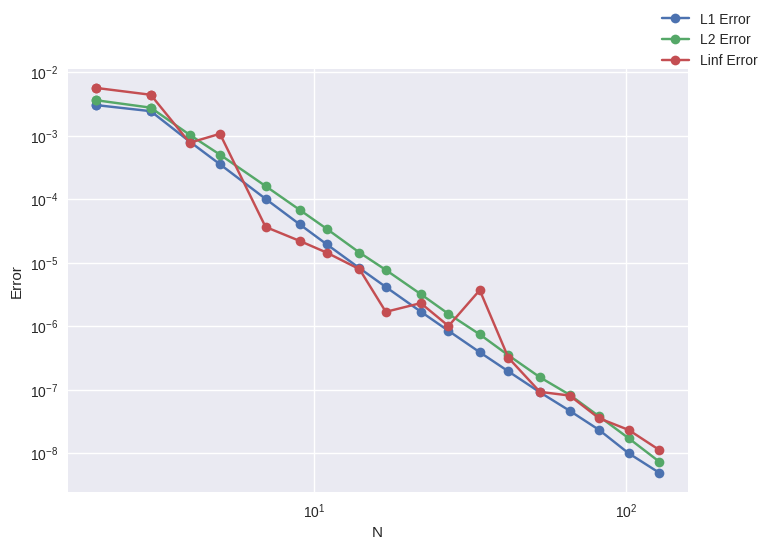

In [46]:
# plot errors over N

u_f, u_fpp, u_b, u_a_ij = funcs["f3_quad"]

x0, xN = 0, 1
fine_x = np.linspace(x0, xN, num=10000)

u_anal = u_f(fine_x)

temp1, temp2, temp3 = [], [], []

ns = np.logspace(
    np.log2(3) // 1, np.log2(200) // 1, base=2, dtype=int, num=20
)  # get k integers between a,b evenly spaced in logspace

# ns = np.arange(3, 60)

fig, ax = plt.subplots()

for N in ns:
    print(f"N:{N}", end="\r")  # counter for computation
    h = (xN - x0) / (N)

    a = np.array([[u_a_ij(i, j, h) for j in range(1, 2 * N)] for i in range(1, 2 * N)])
    b = np.array([u_b(i, h) for i in range(1, 2 * N)])
    # b = np.array([b_j(i, h, used_fpp, x0, xN) for i in range(1, N)]) # numerical b
    x = np.linalg.solve(a, b)

    x_grid = np.linspace(x0, xN, num=N + 1)
    u_num_corse = np.pad(x[1::2], 1, "constant", constant_values=0)

    temp1.append(l1_err_func(u_f, u_num_corse, x_grid, 2))
    temp2.append(l2_err_func(u_f, u_num_corse, x_grid, 2))
    temp3.append(linf_err_func(u_f, u_num_corse, x_grid, 2))


l1_errors = np.array(temp1)
l2_errors = np.array(temp2)
linf_errors = np.array(temp3)

ax.plot(ns, l1_errors, "-o", label="L1 Error")
ax.plot(ns, l2_errors, "-o", label="L2 Error")
ax.plot(ns, linf_errors, "-o", label="Linf Error")

ax.set_xlabel("N")
ax.set_ylabel("Error")
ax.set_xscale("log")
ax.set_yscale("log")
fig.legend()

for errors, label in zip(
    [l1_errors, l2_errors, linf_errors], ["L1 Error", "L2 Error", "Linf Error"]
):
    # as y = c x^n
    # log(y) = log(c) + n*log(x)
    # so we find the convergence order n by linear regression
    slope, intercept = np.polyfit(np.log(ns), np.log(errors), 1)
    print(f"{label:>10} = {np.exp(intercept):#.2}*N^{slope:#.2}")